## Text Analysis of Trump's Tweets Using Topic Modeling

In this project, I use exploratory data analysis, sentiment analysis and topic modeling in order to analyze the semantic characteristics of Trump's Twitter.

##### Author: Jessica Khaskheli
##### Collaborators: None
##### Date: June 6, 2022

## **Content Warning**
This project contains harmful and offensive language.

In [36]:
# reading in packages
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords 
stopeng = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import option_context
from itertools import product
from collections import defaultdict
import gensim
import pickle
from gensim import matutils, models
import scipy.sparse

In [2]:
trump = pd.read_csv("trump_20200530.csv")

# getting overview of df
trump.info()

# checking dimensions
trump.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18467 entries, 0 to 18466
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   source          18467 non-null  object
 1   text            18467 non-null  object
 2   created_at      18467 non-null  object
 3   retweet_count   18467 non-null  int64 
 4   favorite_count  18467 non-null  int64 
 5   is_retweet      18409 non-null  object
 6   id_str          18467 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 1010.0+ KB


(18467, 7)

##### Q1) Organizing the data into Document-term matrix 

##### Plan:
I will write code to clean Trump's tweets. I plan to remove all punctuation marks, make sure all of the letters are lowercase and all special characters are removed. I've done some exploration of the dataset before I clean to understand its shape, datatypes and how to move forward with cleaning.

In [3]:
# checking for NaN entries
trump.isna().sum()

# dropping NaN rows (58 from is_retweet)
trump = trump.dropna()
trump.shape

(18409, 7)

In [4]:
trump.head(3)

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,RT @ScottAdamsSays: Malaria drug and zinc the ...,05-30-2020 03:26:31,10566,0,True,1266571665204527109
1,Twitter for iPhone,RT @YoungDems4Trump: In Democrat cities you ca...,05-30-2020 03:21:41,22320,0,True,1266570449431003138
2,Twitter for iPhone,RT @YoungDems4Trump: So sad. This poor busines...,05-30-2020 03:21:32,23961,0,True,1266570411678019584


In [5]:
# only using non-retweet tweets
trump.drop(trump.index[trump['is_retweet'] == True], inplace=True)

# making sure RT fields are dropped
trump['is_retweet'].value_counts()

# re-indexing df
trump.reset_index(drop=True)

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,Time for a change! #2020 https://t.co/AECy2GBfys,05-30-2020 03:20:18,42879,164022,False,1266570099454103553
1,Twitter for iPhone,https://t.co/mljmx2o0G7,05-29-2020 19:46:15,48713,176310,False,1266455834457968640
2,Twitter for iPhone,Looting leads to shooting and that’s why a man...,05-29-2020 18:20:06,52444,241219,False,1266434153932894208
3,Twitter for iPhone,....It was spoken as a fact not as a statement...,05-29-2020 18:20:06,31263,158594,False,1266434155543506945
4,Twitter for iPhone,REVOKE 230!,05-29-2020 15:15:41,38582,195262,False,1266387743996870656
...,...,...,...,...,...,...,...
16504,Twitter for iPhone,January 20th 2017 will be remembered as the da...,01-20-2017 17:53:17,60604,218555,False,822502270503972872
16505,Twitter for iPhone,What truly matters is not which party controls...,01-20-2017 17:52:45,42790,180394,False,822502135233384448
16506,Twitter for iPhone,power from Washington D.C. and giving it back ...,01-20-2017 17:51:58,18362,91143,False,822501939267141634
16507,Twitter for iPhone,Today we are not merely transferring power fro...,01-20-2017 17:51:25,20125,109640,False,822501803615014918


In [6]:
# converting dates to date time format
trump['created_at'] = pd.to_datetime(trump['created_at'])

# setting index as date and time of tweet
trump.set_index('created_at')

,source,text,retweet_count,favorite_count,is_retweet,id_str
created_at,,,,,,
2020-05-30 03:20:18,Twitter for iPhone,Time for a change! #2020 https://t.co/AECy2GBfys,42879,164022,False,1266570099454103553
2020-05-29 19:46:15,Twitter for iPhone,https://t.co/mljmx2o0G7,48713,176310,False,1266455834457968640
2020-05-29 18:20:06,Twitter for iPhone,Looting leads to shooting and that’s why a man...,52444,241219,False,1266434153932894208
2020-05-29 18:20:06,Twitter for iPhone,....It was spoken as a fact not as a statement...,31263,158594,False,1266434155543506945
2020-05-29 15:15:41,Twitter for iPhone,REVOKE 230!,38582,195262,False,1266387743996870656
...,...,...,...,...,...,...
2017-01-20 17:53:17,Twitter for iPhone,January 20th 2017 will be remembered as the da...,60604,218555,False,822502270503972872
2017-01-20 17:52:45,Twitter for iPhone,What truly matters is not which party controls...,42790,180394,False,822502135233384448
2017-01-20 17:51:58,Twitter for iPhone,power from Washington D.C. and giving it back ...,18362,91143,False,822501939267141634


In [7]:
trump_tweetslist = trump['text'].tolist() # converting to list to preserve order of tweets for cleaning

In [8]:
# same cleaning code from previous PS 
cleaned_trump_tweets = []
for row in trump_tweetslist:
    row  = re.sub('[.-]', '', row)
    row = row.lower()
    #remove urls
    row  = re.sub(r'http\S+', '', row)
    #remove mentions
    row = re.sub(r"(?<![@\w])@(\w{1,25})", '', row)
    #remove hashtags
    row = re.sub(r"(?<![#\w])#(\w{1,25})", '',row)
    #remove other special characters
    row = re.sub('[^A-Za-z .-]+', '', row) 
    # removing rt in text
    row  = re.sub(r'rt', '', row)
    #remove digits
    row = re.sub('\d+', '', row)
    row = row.strip(" ")
    row = re.sub('\s+', ' ', row)
    row = re.sub('\-','', row)
    row = re.sub('\.','', row)
    row = re.sub('\n','', row)
    row = re.sub('\,','', row)
    tokens = word_tokenize( row.lower() )
    tokens_nostop = [w for w in tokens if w not in stopeng]
    cleaned_title = " ".join(tokens_nostop)
    cleaned_trump_tweets.append(cleaned_title)

In [9]:
# creating dataframe of clean tweets for later use
clean_tweet_df = pd.DataFrame()
clean_tweet_df['tweet'] = cleaned_trump_tweets

In [10]:
# creating df for cleaned text to use for document term matrix
clean_text = pd.DataFrame()
clean_text['text'] = cleaned_trump_tweets

##### Comments:
I created one dataframe with the cleaned tweets to use for my document term matrix, and another dataframe with cleaned tweets to use for profanity analysis later on in this project. I removed RTs from the dataframe and removed the phrase 'RT' from the corpus. This was done because even after RTs were removed, the text in non-retweet tweets contained 'RT'.

In [11]:
##### Creating document term matrix using CountVectorizer

##### Plan:
I plan to use `CountVectorizer` to convert my dataframe into a document term matrix. I then plan to transpose the matrix so that the corpus is indexed by the words instead of numerical indices. This will make it easier to find the most common words later on.

In [12]:
cv = CountVectorizer(stop_words='english') # removing stopwords again first
clean_text_cv = cv.fit_transform(clean_text.text)
clean_text = pd.DataFrame(clean_text_cv.toarray(), columns=cv.get_feature_names())
clean_text

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aa,aaa,aand,aap,ab,abaco,abandon,abandoned,abbas,abbott,...,zone,zones,zoning,zoo,zoom,zte,zucker,zuckerberg,zuckers,zuker
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16504,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16505,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16506,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16507,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# pickling data frame to serialize data to a file for easier handling when calculating common words
clean_text.to_pickle("pickled_text.pkl")
data = pd.read_pickle('pickled_text.pkl')
data = data.transpose() # transposing the matrix so that now the words are the rows so it's easier to take the sum 

##### Comments:
I pickled the document term matrix and transposed it so that I can now calculate the common words in the corpus.

##### Q2). Finding the most common words  used in Trump's Twitter (EDA)

##### Plan:
Since I've indexed the DTM with the words instead of the numerical indices, I plan to compute the sum across each row and then sort the dataframe so that the words with the highest sum are shown at the head of the dataframe. I then plan to display the first 30 rows.

In [14]:
words_freq = data.sum(axis = 1).sort_values(ascending=False).head(30) # summing each row to calc total freq
common_words = pd.DataFrame(words_freq)
common_words.reset_index(inplace = True) # reindexing to include word as column
common_words.rename(columns = {'index':'word', 0:'freq'}, inplace = True)
common_words

,word,freq
0,great,2960
1,amp,2423
2,president,1756
3,people,1530
4,democrats,1295
5,thank,1186
6,trump,1173
7,news,1116
8,country,1005
9,fake,941


##### Inferences:
By seeing the top 30 words, I can infer that Trump tweets mostly about people, democrats, fake news, America and 'big', 'great', and 'new' related content. This tweets look like they're mostly America related and I also see the word 'border' as one of the top 20 words used, meaning he discusses building the wall quite often.

##### Q3). Visualizing the data 

##### Plan:
* For my first visualization, my plan is to continue using the top 30 words from this corpus for plotting because it seems like a realistic size to analyze and visually compare word frequencies. I first want to plot a barplot of the top 30 words, with the x-axis being the frequency of the word. This will make it easy to see the word and length of the bar and compare it with the other words included.

* For the second visualization, I plan to plot a `relplot` to visualize the top 30 word frequencies in a line plot form. I think this would be an interesting way to observe the connection between the top words used since they'll all be connected with a singular line as opposed to a bar plot that's designated for each word separately.

##### Visualization 1

Text(0, 0.5, 'Word')

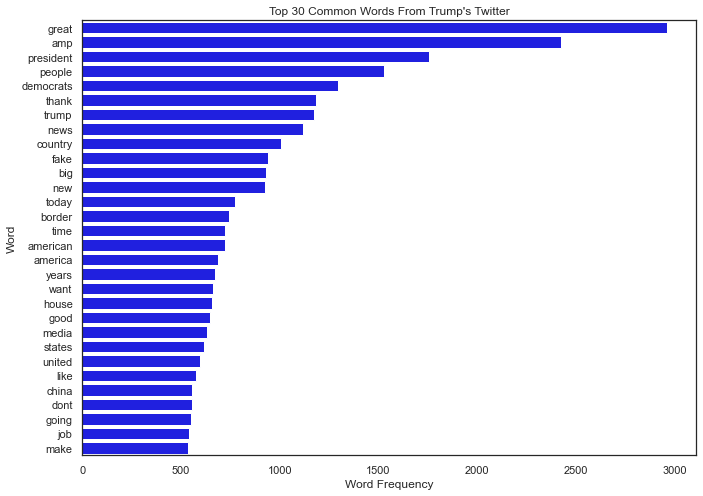

In [15]:
sns.set(rc={'figure.figsize':(11,8)})
sns.set_style("white")
sns.barplot(x = 'freq', y = 'word', color = 'blue', data = common_words)
plt.title("Top 30 Common Words From Trump's Twitter")
plt.xlabel("Word Frequency")
plt.ylabel("Word")

##### Inferences:
* Similar to what I stated in Q2), 'great', 'amp' and 'president' are amongst the top words that occur in this corpus. I might infer that Trump's Twitter might contain a nontrivial number of positive sentiment tweets by the amount of times he uses the words 'great', 'thank', 'big' and 'new'.

##### Visualization 2

<Figure size 2160x2160 with 0 Axes>

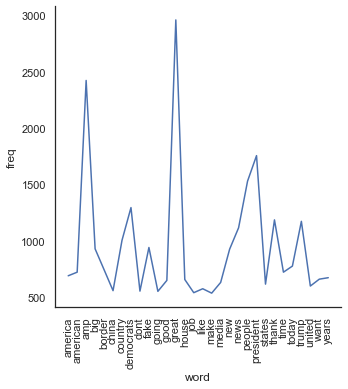

<Figure size 2160x2160 with 0 Axes>

In [16]:
#sns.set(rc={'figure.figsize':(100,100)})
sns.set_style('white')
sns.relplot(
    data=common_words,
    x="word", y="freq", kind = 'line')
plt.xticks(rotation = 90)
plt.figure(figsize=(30,30))

##### Inferences:
* The words in the `relplot` are alphabetized from A-Z which created a different shape compared to the bar plot that follows a high to low frequency order. In this case, we can compare the highly occuring words to the lower occuring words. For example, we can see that words like "country", and "democrats" are within the same word frequency window, "fake" has its own frequency peak and "great" has the highest peak amongst all of the words. This plot creates several significant peaks which separates the most significant words from the less significant ones. We can see that "amp", "country", "democrats", "fake", "great", "people", "news", "thank", and "trump" are amongst the most significant words. Similar results can be see in the barplot above but it might be difficult to figure out where the separation between most significant to least significant words should occur.

##### Q4). Amount of Profanity in my data  

##### Plan: Profanity

I want to explore how often Trump used profanity in his tweets. I define profanity as language that is offensive, rude, or abusive. This includes swear words, sexually-connotated words, misogynistic words and racial slurs. I plan to import the Swear dimension from the LIWC dictionary in order to assess the amount of profanity that exists across Trump's twitter. I will write code that will mark a tweet with the word 'swear' or 'NaN' and then count the number of times 'swear' appears in the corpus. The LIWC Swear dimension includes swear words, sexually-conntotated words, misoginistic words and racial slur words and my assumption is that the number of words in the Swear dimension will be sufficient to capture the amount of profanity from Trump's tweets.

In [17]:
# reading in liwc swear dict
swear_lexicon = pd.read_csv("liwc_swear.csv")

In [18]:
# adding column headers and fixing df to include term as row instead of column name
swear_lexicon.iloc[0] = ['af', 'swear']
swear_lexicon.rename(columns = {'af':'term', 'swear': 'dim'}, inplace = True)
swear_lexicon.head(3)

,term,dim
0,af,swear
1,arsehole,swear
2,arses,swear


In [19]:
swear_dict = {} # creating empty dictionary for profane words
liwc_swear = {column[0] : column[1] for _, column in pd.read_csv("liwc_swear.csv").iterrows()} # creating key and vals
swear_dict.update(liwc_swear) # updating dict with swear words key and value pairs

In [20]:
# adding a 'Value' column to mark if a tweet is profane or not
clean_tweet_df['Value'] = clean_tweet_df['tweet'].str.extract('('+'|'.join(swear_dict)+')', expand=False).map(swear_dict)

# extracting all profane tweets to inspect contents
trump.drop(trump.index[trump['is_retweet'] == True], inplace=True)
clean_tweet_df = pd.DataFrame(clean_tweet_df) # df with only profane tweets
swear_tweets_only = clean_tweet_df.dropna()

with option_context('display.max_colwidth', None):
    display(swear_tweets_only.head(10))
    
print('Number of Tweets with Profanity:', swear_tweets_only.shape)
print('Total Shape of Clean Corpus:', clean_tweet_df.shape)
print('Percentage of Profane Tweets:', (3478 / 16509)*100,'%')


,tweet,Value
5,national guard arrived scene minneapolis fully prepared george floyd died vain respect memory,swear
12,thugs dishonoring memory george floyd wont let happen spoke governor tim walz told military way difficulty assume control looting stas shooting stas thank,swear
13,mailin voting lead massive fraud abuse also lead end great republican pay never let tragedy befall nation big mailin victory texas cou today congrats,swear
18,im proud commit funding milwaukees eastwest bus rapid transit project bringing modern transit regions critical corridor spur millions economic development love wisconsin,swear
21,max red line oregon set receive funds reduce delays poland area connect citizens impoant locations make transit great,swear
22,proud commit funding provide brand new bus system busy popular transit corridor albany ny areamore help coming people new york,swear
23,indiana set receive transit funds connect people jobs around state chicagoarea help cut traffic worked hard project,swear
24,big announcement state indiana committed funds gamechanging transit project provide fast frequent service people indianapolis lawrence,swear
25,im excited commit fl funding connect fastgrowing communities stateofthea transit service fast safe beautiful infrastructure,swear
27,exciting news phoenix area committing mile light rail system new stations connecting underserved areas churches emergency services,swear


Number of Tweets with Profanity: (3478, 2)
Total Shape of Clean Corpus: (16509, 2)
Percentage of Profane Tweets: 21.067296626082744 %


In [21]:
# creating a dataframe of the swear terms from the liwc dictionary that show up in the corpus
swear_array = swear_lexicon.term.str.lower().array
d = defaultdict(list)
for w, word in product(clean_tweet_df.tweet, swear_array): # appendign swear word to dict
    if word in w.lower():
        d[w].append(word)

swear_lexicon['term'] = clean_tweet_df.tweet.map(d).str.join(',') # appending swear word to df

In [23]:
# creating df to plot all swear words trump used in tweets with their frequencies
swear_plot = swear_lexicon.term.value_counts().rename_axis('unique_terms').reset_index(name='counts')
swear_plot = swear_plot.iloc[1: , :] # dropping first row that doesn't give useful info
print(swear_plot)

   unique_terms  counts
1            fu      13
2            bs       5
3            af       4
4           ass       2
5         af,fu       2
6      af,bs,fu       1
7           hoe       1
8           tit       1
9        af,ass       1
10         dang       1
11     ass,heck       1
12         hell       1
13         heck       1


Text(0, 0.5, 'Profane Term')

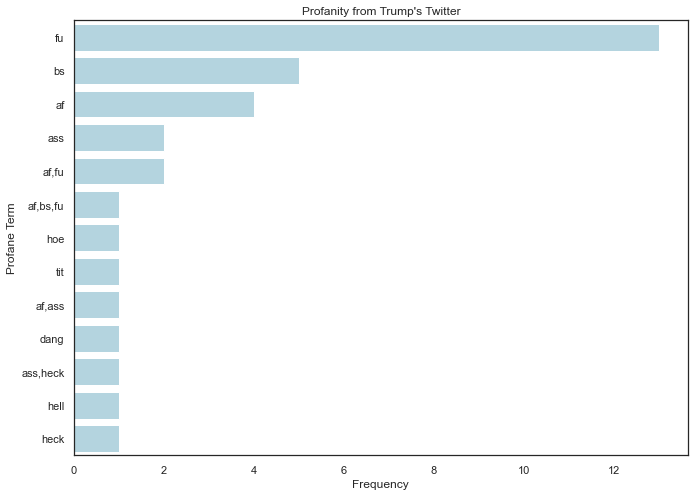

In [24]:
sns.set(rc={'figure.figsize':(11,8)})
sns.set_style("white")
sns.barplot(x = 'counts', y = 'unique_terms', color = 'lightblue', data = swear_plot)
plt.title("Profanity from Trump's Twitter")
plt.xlabel("Frequency")
plt.ylabel("Profane Term")

##### Comments:
* From the barplot above, we can see that the F bomb, 'bs', and 'ass' are amongst the most frequently occuring swear words and profanity that Trump tweets. My inference is that he might be using the F bomb against people that oppose him, or policies that he's against, especially because we see the term 'bs' which would usually mean that something is bogus or fake.
* We get a percentage of 21.6% of profanity related content from Trump's twitter. I'm not sure about the proportion of profanity related content from past presidents on Twitter but my inference is that this proportion is on the high end of profanity related content for a president. 

##### Q5). Topic Modeling of Trump's Tweets

##### Plan:
My plan is to implent LDA in order to conduct topic modeling. I want to compress the sparse DTM in order to reformat it to use with `gensim`. I will create a dictionary with the associated key and value pairs to work with `gensim` as well. Then I will call the LDA model and analyze the topics that are produced.

In [29]:
sparse_matrix = scipy.sparse.csr_matrix(data) # compressed sparse doc term matrix
corpus = matutils.Sparse2Corpus(sparse_matrix)

In [33]:
tweet_cv = cv.fit_transform(clean_tweet_df['tweet'])
features = pd.DataFrame(tweet_cv.toarray(), columns=cv.get_feature_names())
features.index = clean_tweet_df['tweet'].index 

pickle.dump(cv, open("cv_tweet.pkl", "wb"))

In [34]:
cv = pickle.load(open("cv_tweet.pkl", "rb"))
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

##### Topic Modeling Attempt 1

In [94]:
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=1, passes=10)
lda.print_topics()

[(0,
  '0.016*"govern" + 0.012*"americathese" + 0.007*"patel" + 0.007*"poway" + 0.006*"navarro" + 0.005*"delighted" + 0.005*"facebook" + 0.005*"betwe" + 0.005*"could" + 0.005*"taxing"')]

After my first attempt at topic modeling, I see that the results I've obtained are fairly nuanced and I want to experiment with the kinds of topics I would obtain if I were to pass the model through the entire corpus 20 times instead of 10.

##### Topic Modeling Attempt 2

In [35]:
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=20)
lda.print_topics()

[(0,
  '0.013*"news" + 0.012*"democrats" + 0.012*"fake" + 0.012*"amp" + 0.010*"trump" + 0.008*"president" + 0.008*"media" + 0.007*"people" + 0.006*"dont" + 0.006*"bad"'),
 (1,
  '0.027*"great" + 0.012*"amp" + 0.009*"thank" + 0.008*"today" + 0.007*"people" + 0.007*"big" + 0.007*"america" + 0.007*"country" + 0.006*"border" + 0.006*"president"')]

##### Inferences:
* For the first attempt at topic modeling, I kept the number of passes relatively low because the corpus is pretty larger. Therefore, I decided that 10 passes may be enough to gain relevant topics. From the first attempt, we can see that we get "govern", "facebook", "americanthese", "taxing" and others. I can infer that Trump frequently discusses about governing issues, potential fake news on Facebook, and tax issues which might be related to the criticism of Trump not paying his taxes by the public. For my first attempt, it seems like I retrieved fairly interpretable topics given my previous knowledge of Trump's online behavior and the common words he uses in his tweets.

* For my second attempt, I decided to increase the number of passes through the corpus to 20 to see if I could get a more representative set of topics. I see topics like "big", "media", "border", "democrats" and others which are most closely related to the common words I extracted in the beginning of this project. Compared to the the first attempt, these topics are more obvious and the first attempt topics seem more nuanced and interesting. This makes me infer that 10 passes through the corpus might've been enough to get interpretable and significant topics.

##### Q6). Analyzing the sentiment of popular tweets

##### Plan:
I want to explore the sentiment of Trump's most favorited tweets to see what kinds of tweets got him the most likes. Therefore, my research question is:

* How does the sentiment scores of Trump's most favorited tweets vary?

I will manually inspect the content of some of his most rated tweets to better understand the context. I also aim to filter the dataframe to only plot tweets that got more than 200,000 favorites. This is most than three times larger than the mean number of favorites and I did this so that the points are more clearly visable. I will conduct sentiment analysis with VADER because I find that VADER might work better on tweet data since it's less formal in language.

In [37]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader_senti = []
written_senti = []
for i in range(len(clean_tweet_df['tweet'])):
        analyzer = SentimentIntensityAnalyzer()
        scores = analyzer.polarity_scores(clean_tweet_df.tweet.iloc[i])
        vader_senti.append(scores)
        if scores['compound'] >= 0.5:
            written_senti.append("Positive Sentiment")
        elif scores['compound'] < 0:
            #print("Negative Sentiment")
            written_senti.append("Negative Sentiment")
        else:
            #print("Neutral Sentiment")
            written_senti.append("Neutral Sentiment")
            
vader_df = pd.DataFrame(vader_senti)

In [40]:
# appending score and senitment to dataframe
pd.DataFrame(written_senti).value_counts()
written_df = pd.DataFrame(written_senti)
t = trump.reset_index(drop=True)

In [41]:
# appending dates and favorite count to vader df
vader = pd.DataFrame(vader_senti)
vader['sentiment'] = written_df
vader['fav'] = t['favorite_count']
vader['date'] = t['created_at']
vader['tweet'] = t['text']
vader.shape

(16509, 8)

In [42]:
t['favorite_count'].describe() # analyzing statistics of favorite count from original trump dataframe

count     16509.000000
mean      65166.230783
std       60426.310143
min           0.000000
25%           0.000000
50%       64338.000000
75%       95009.000000
max      879647.000000
Name: favorite_count, dtype: float64

Text(0, 0.5, 'Favorite Count')

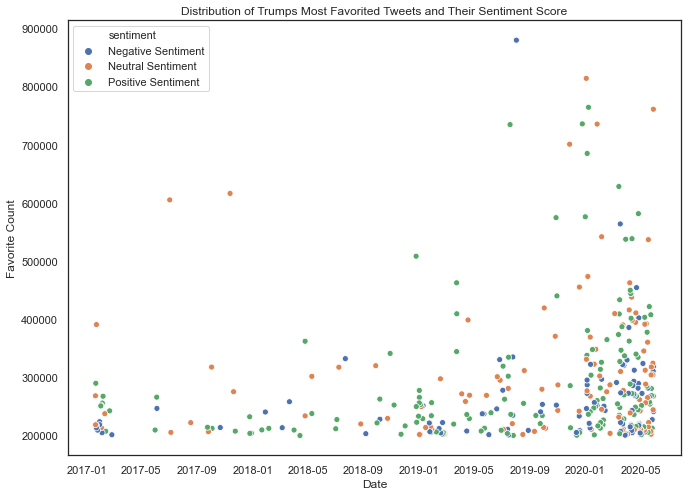

In [43]:
faves = vader[~(vader['fav'] < 200000)]
sns.scatterplot(x = 'date', y = 'fav', hue = 'sentiment', data = faves)
plt.title('Distribution of Trumps Most Favorited Tweets and Their Sentiment Score')
plt.xlabel('Date')
plt.ylabel('Favorite Count')

In [44]:
faves.sentiment.value_counts() # number of positive, negative and neutral tweets above 200k favorites

Positive Sentiment    150
Neutral Sentiment     108
Negative Sentiment     90
Name: sentiment, dtype: int64

Most tweets within the top favorited tweets are still positive in sentiment, however, I see most tweets being negative in sentiment clustered in the 2020 year range compared to other years.

In [45]:
top_faves = faves.sort_values('fav', ascending=False)
with option_context('display.max_colwidth', None):
    display(top_faves.head(20))

,neg,neu,pos,compound,sentiment,fav,date,tweet
8023,0.173,0.681,0.147,-0.1280,Negative Sentiment,879647,2019-08-02 17:41:30,A$AP Rocky released from prison and on his way home to the United States from Sweden. It was a Rocky Week get home ASAP A$AP!
4399,0.000,0.000,0.000,0.0000,Neutral Sentiment,814012,2020-01-03 02:32:53,https://t.co/VXeKiVzpTf
4316,0.080,0.606,0.314,0.7579,Positive Sentiment,764333,2020-01-08 02:45:24,All is well! Missiles launched from Iran at two military bases located in Iraq. Assessment of casualties &amp; damages taking place now. So far so good! We have the most powerful and well equipped military anywhere in the world by far! I will be making a statement tomorrow morning.
7,0.000,1.000,0.000,0.0000,Neutral Sentiment,760988,2020-05-29 13:01:56,CHINA!
4527,0.000,0.222,0.778,0.5423,Positive Sentiment,735775,2019-12-25 12:26:31,MERRY CHRISTMAS!
3652,0.277,0.405,0.318,0.4215,Neutral Sentiment,735478,2020-01-26 23:54:34,Kobe Bryant despite being one of the truly great basketball players of all time was just getting started in life. He loved his family so much and had such strong passion for the future. The loss of his beautiful daughter Gianna makes this moment even more devastating....
8315,0.000,0.554,0.446,0.8979,Positive Sentiment,734567,2019-07-19 20:01:47,Just spoke to @KanyeWest about his friend A$AP Rocky’s incarceration. I will be calling the very talented Prime Minister of Sweden to see what we can do about helping A$AP Rocky. So many people would like to see this quickly resolved!
4918,0.000,0.000,0.000,0.0000,Neutral Sentiment,700861,2019-11-27 15:54:39,https://t.co/11nzKwOCtU
4359,0.081,0.562,0.357,0.8694,Positive Sentiment,684981,2020-01-05 05:11:03,The United States just spent Two Trillion Dollars on Military Equipment. We are the biggest and by far the BEST in the World! If Iran attacks an American Base or any American we will be sending some of that brand new beautiful equipment their way...and without hesitation!
2161,0.000,0.235,0.765,0.7579,Positive Sentiment,628164,2020-03-14 17:31:56,THE UNITED STATES LOVES ITALY! https://t.co/DESUJ4QM41


##### Interpretation:
With respect to my research question, I plotted the most favorited tweets, which I defined as having more than 200,000 favorites, against the date they were tweeted because I thought this would be better for contextuality. I also wanted to see how the sentiment of the most favorited tweets changed over time and if more negative sentiment tweets were favorited or positive sentiment tweets. From my plot, I observe that mostly positive and neutral sentiment tweets achieve the most favorites as we can see more orange and green points closer to the top of the graph. Although, an interesting finding is that the tweet with the maximum number of favorites has a negative sentiment score. When I saw this, I decided to order the dataframe from highest favorite count to lowest favorite count so that I could inspect the context of the negative sentiment tweet with the more favorites. From the dataframe above, we can see that the top favorited tweet is about ASAP Rocky being released from prison. Looking at the other top favorited tweets, we see that Trump tweets messages with all caps and an exclamation point about holidays like Easter, Christmas and birthdays. He also tweets about insisting to reopen the country during lockdown in all caps and an exclamation point which is rated as neutral sentiment. This makes me wonder if the all caps and exclamation point is misleading because this might be considered negative sentiment when consider this being in the context of a pandemic. Overall, I observe a lot more tweets getting more than 200,000 favorites towards the end of his presidential term in 2020, and there is a larger concentration of negative sentiment tweets at the end of his presidential term as well.